# Reconstruction comparison

In [ ]:
from nbodykit.lab import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0

input_cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

fof = FOF(input_cat, linking_length=0.2, nmin=5)
halos = fof.to_halos(cosmo=cosmo, redshift=redshift, particle_mass=1e12, mdef='vir')

In [ ]:
delta_m = input_cat.to_mesh(interlaced=True, compensated=True, resampler='cic')
r = FFTPower(delta_m, mode='1d')
Pkm = r.power['power'].real - r.power.attrs['shotnoise']
k = r.power['k']
mask = (k>0.01) * (k<0.1)

In [ ]:
nbar = halos.csize/(1380.**3)

In [ ]:
delta = halos.to_mesh(interlaced=True, compensated=True, resampler='cic')

In [ ]:
r = FFTPower(delta, mode='1d')
Pkh = r.power['power'].real - r.power.attrs['shotnoise']

bg = np.mean(np.sqrt(Pkh[mask]/Pkm[mask]))
bg

2.7992906806209197

In [ ]:
# Hard coded reconstruction
psi = compute_zeld(1380., 256, delta.apply(divide_bias, mode='real', kind='index').apply(filters.Gaussian(r=20).filter, mode='complex', kind='wavenumber').paint(mode='real'))
halos['Position_zinit'] = displace_galaxies(psi, halos['Position'].compute(), 256, 1380., zinit=1., zobs=.55)
delta_gzinit = halos.to_mesh(position='Position_zinit', resampler='cic', interlaced=True, compensated=True)

In [ ]:
# FFTRecon from nbodykit
ran = UniformCatalog(nbar, 1380.)
delta_compare = FFTRecon(halos, ran, 256, bias=bg)

In [ ]:
# mimic nbkit (but with final redshift)
ran['Position_zinit'] = displace_galaxies(psi, ran['Position'].compute(), 256, 1380., zinit=1., zobs=.55)
delta_ranzinit = ran.to_mesh(position='Position_zinit', resampler='cic', interlaced=True, compensated=True, Nmesh=256)
delta_recon = delta_gzinit.paint(mode='real') - delta_ranzinit.paint(mode='real')
delta_recon = ArrayMesh(delta_recon, 1380.)

In [ ]:
r = FFTPower(delta_gzinit, mode='1d')
Pkrecon1 = r.power['power'].real - r.power.attrs['shotnoise']
r = FFTPower(delta_compare, mode='1d')
Pkrecon2 = r.power['power'].real - r.power.attrs['shotnoise']
r = FFTPower(delta_recon, mode='1d')
Pkrecon3 = r.power['power'].real - r.power.attrs['shotnoise']


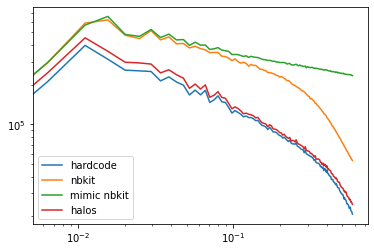

In [ ]:
plt.loglog(k, Pkrecon1, label='hardcode')
plt.loglog(k, Pkrecon2, label='nbkit')
plt.loglog(k, Pkrecon3, label='mimic nbkit')
plt.loglog(k, Pkh, label='halos')
plt.legend()

In [ ]:
brecon1 = np.mean(np.sqrt((Pkrecon1/Pkm)*(D(0.55)/D(1))))
brecon2 = np.mean(np.sqrt((Pkrecon2/Pkm)*(D(0.55)/D(1))))
brecon3 = np.mean(np.sqrt((Pkrecon3/Pkm)*(D(0.55)/D(1))))

print(brecon1, brecon2, brecon3)

4.930995878344929 7.655263515578798 11.04728492725976


In [ ]:
# expected
bgzinit_e = (bg - 1)*(D(0.55)/D(1)) + 1

print(bgzinit_e)

3.2212975820770855


In [ ]:
zobs = 0.3
zrec = 3.
bzobs = 1.3

# Valores de formulas
breczrect = (bzobs-1)*(D(zobs)/D(zrec)) + 1
breczobst = (bzobs-1) + (D(zrec)/D(zobs))
print(breczrect, breczobst)
print(D(zobs)/D(zrec)*0.06)

breczrecs = np.sqrt((breczrect + f(zrec)/3)**2 + 4*(f(zrec)**2)/45)
breczobss = np.sqrt((breczobst + f(zobs)/3)**2 + 4*(f(zobs)**2)/45)
print(breczrecs, breczobss)

1.808871393397001 0.670887142812773
0.16177427867940017
2.1559610006159384 0.9198696225068889


In [ ]:
zobs = 0.3
zrec = 3.
bzobs = 1.3

# Valores de formulas
breczrect = (bzobs-1)*(D(zobs)/D(zrec)) + 1
breczobst = (bzobs-1) + (D(zrec)/D(zobs))
print(D(zobs)/D(zrec)*0.02)
print(breczrect, breczobst)
# print(D(zobs)*breczobst, D(zrec)*breczrect)

bsreczrect = np.sqrt((breczrect + f(zrec)/3)**2 + 4*(f(zrec)**2)/45)
bsreczobst = np.sqrt((breczobst + f(zobs)/3)**2 + 4*(f(zobs)**2)/45)
print(bsreczrect, bsreczobst)

0.053924759559800056
1.808871393397001 0.670887142812773
2.1559610006159384 0.9198696225068889


In [ ]:
# # Valores simulacion
# bsreczrec = 2.88
# bsreczobs = 1.07
# #print(D(zobs)*bsreczobs, D(zrec)*bsreczrec)


# breczobssim = (-f(zobs)/3) + np.sqrt((-4*(f(zobs)**2)/45) + (bsreczobs)**2)
# breczrecsim = (-f(zrec)/3) + np.sqrt((-4*(f(zrec)**2)/45) + (bsreczrec)**2)
# print(breczrecsim, breczobssim)

# breczrec = 2.43
# breczobs = 0.9
# bsreczrecsim = np.sqrt((breczrec + f(zrec)/3)**2 + 4*(f(zrec)**2)/45)
# bsreczobssim = np.sqrt((breczobs + f(zobs)/3)**2 + 4*(f(zobs)**2)/45)
# print(bsreczrecsim, bsreczobssim)

In [ ]:
# redshift bias from zobs my eqs
bsreczrec = np.sqrt(((bzobs-1)*(D(zobs)/D(zrec))+ 1 + f(zrec)/3)**2 + 4*(f(zrec)**2)/45)
bsreczobs = np.sqrt((bzobs-1 + (D(zrec)/D(zobs))+ f(zobs)/3)**2 + 4*(f(zobs)**2)/45)
print(bsreczrec, bsreczobs)

2.0491616457400315 0.8808950140164269


In [ ]:
np.sqrt((2.07 + (f(zrec)/3))**2 + (4*(f(zrec)**2)/45))

2.4149335545116744

In [ ]:
np.sqrt((1.95 + (f(zobs)/3))**2 + (4*(f(zobs)**2)/45))

2.1858153740284725

In [ ]:
(1.35*(D(zobs)/D(zrec))+1)

4.639921270286504

In [ ]:
1.35 + (D(zrec)/D(zobs))

1.720887142812773

In [ ]:
2.03*(D(zrec)/D(zobs))

0.7529008999099288

In [ ]:
(-f(zobs)/3) + np.sqrt((-4*(f(zobs)**2)/45) + (2.07)**2)

1.8336561603042987

In [ ]:
print(0.7*D(0.3), 1.87*D(3.0))

0.5978681500822169 0.5923668723290648
